In [3]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [4]:
trData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')
data_list = [trData, testData]
trData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Cleaning
## The columns which are not numeric will be converted to numeric and the columns with too many NaNs will be removed (e.g., the Cabin)

In [5]:
print("Total number of samples in train set is:", len(trData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(trData.isnull().sum())
print("*"*70)
print("Total number of samples in test set is:", len(testData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(testData.isnull().sum())

Total number of samples in train set is: 891
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
**********************************************************************
Total number of samples in test set is: 418
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
print(len(trData['PassengerId'].unique()))
print(len(trData['Ticket'].unique()))

891
681


In [7]:
dropped_features = ['PassengerId', 'Ticket', 'Cabin']

In [8]:
for data in data_list:
    data['Age'].fillna(trData['Age'].median(), inplace = True)
    data['Embarked'].fillna(trData['Embarked'].mode()[0], inplace = True)

In [9]:
print("Total number of samples in train set is:", len(trData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(trData.isnull().sum())
print("*"*70)
print("Total number of samples in test set is:", len(testData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(testData.isnull().sum())

Total number of samples in train set is: 891
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64
**********************************************************************
Total number of samples in test set is: 418
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


### The Cabin column will be dropped, but the Fare column of the test set has a missing value; we could replace it with median but because Fare is very corelated with the class and Pclass is not missing we replace it with the Mean Fare value of the Pclass of the missing row

In [10]:
PclassVsFare = trData[['Pclass','Fare']].groupby(['Pclass'], as_index = False).mean()
PclassVsFare

,Pclass,Fare
0,1,84.154687
1,2,20.662183
2,3,13.675550


In [11]:
testData['Pclass'][testData['Fare'].isnull()] 

152    3
Name: Pclass, dtype: int64

In [12]:
# The passenger with missing class has a Pclass of 3 whose average Fare is 13.67 
testData['Fare'].fillna(PclassVsFare.loc[2,'Fare'], inplace = True);

In [13]:
for data in data_list:
    data['Title'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
testData.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [14]:
testData['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dona        1
Dr          1
Name: Title, dtype: int64

In [15]:
trData['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Jonkheer          1
Ms                1
Capt              1
the Countess      1
Don               1
Sir               1
Mme               1
Lady              1
Name: Title, dtype: int64

In [16]:
min_val = 10
title_names = (trData['Title'].value_counts() < min_val)
trData['Title'] = trData['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

In [17]:
min_val = 5
title_names = (testData['Title'].value_counts() < min_val)
testData['Title'] = testData['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

In [18]:
testData['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Misc        7
Name: Title, dtype: int64

In [19]:
#for data in data_list:
#    data['FareBin'] = pd.qcut(data['Fare'], 4)
#    data['AgeBin'] = pd.cut(data['Age'].astype(int), 5)
#    data['Nfamily'] = data['Parch'] + data['SibSp']

## Transfer categorial values to discrete values

In [20]:
trData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [21]:
trData['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Misc'], dtype=object)

In [22]:
for data in data_list:
    #data['FareBinCode'] = label.fit_transform(data['FareBin'])
    #data['AgeBinCode'] = label.fit_transform(data['AgeBin']) 
    data['SexCode'] = data['Sex'].replace(['female', 'male'], [0, 1])
    data['EmbarkedCode'] = data['Embarked'].replace(['S', 'Q', 'C'], [0, 1, 2])
    data['TitleCode'] = data['Title'].replace(['Mr', 'Mrs', 'Miss', 'Master','Misc'], [0, 1, 2, 3, 4])
    data['Nfamily'] = data['Parch'] + data['SibSp']
    data['IsAlone'] = 1
    data.loc[data['Nfamily'] > 0, 'IsAlone'] = 0

In [23]:
testData.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,SexCode,EmbarkedCode,TitleCode,Nfamily,IsAlone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,1,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,1,1,0,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,1,0,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,0,0,1,2,0


# Statistical Analysis and feature engineering

In [24]:
trData[['Nfamily', 'Survived']].groupby(['Nfamily'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Nfamily,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


In [25]:
trData[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [26]:
trData[['Sex','Survived']].groupby(['Sex'], as_index = False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [27]:
trData[['SibSp','Survived']].groupby(['SibSp'], as_index = False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [28]:
trData['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [29]:
trData[['Pclass','Fare','Survived']].groupby(['Pclass'], as_index = False).mean()

,Pclass,Fare,Survived
0,1,84.154687,0.629630
1,2,20.662183,0.472826
2,3,13.675550,0.242363


In [30]:
pd.crosstab(trData['Sex'], trData['Survived'])

Survived,0,1
Sex,,
female,81,233
male,468,109


In [31]:
trData[['TitleCode','Survived']].groupby(['TitleCode'], as_index = False).mean()

,TitleCode,Survived
0,0,0.156673
1,1,0.792000
2,2,0.697802
3,3,0.575000
4,4,0.444444


In [32]:
age_kid = 16
print("Number of kids younger than {} is {}.".format(age_kid, (trData['Age'] < age_kid).sum()))
kids_survival_rate = trData['Survived'][trData['Age'] < age_kid].sum() / (trData['Age'] < age_kid).sum()
overal_survival_rate = trData['Survived'].sum() / len(trData['Survived'])
print("Survival rate of these kids is {} while the overal survival rate is {}.".format(round(kids_survival_rate, 2), round(overal_survival_rate, 2)))

Number of kids younger than 16 is 83.
Survival rate of these kids is 0.59 while the overal survival rate is 0.38.


In [33]:
for data in data_list:
    data['IsChild'] = (data['Age'] < age_kid) * 1

In [34]:
trData[trData['IsChild'] == 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,SexCode,EmbarkedCode,TitleCode,Nfamily,IsAlone,IsChild
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S,Master,1,0,3,4,0,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,C,Mrs,0,2,1,1,0,1
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.00,1,1,PP 9549,16.7000,G6,S,Miss,0,0,2,2,0,1
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.00,0,0,350406,7.8542,NaN,S,Miss,0,0,2,0,1,1
16,17,0,3,"Rice, Master. Eugene",male,2.00,4,1,382652,29.1250,NaN,Q,Master,1,1,3,5,0,1
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.00,0,0,330923,8.0292,NaN,Q,Miss,0,1,2,0,1,1
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.00,3,1,349909,21.0750,NaN,S,Miss,0,0,2,4,0,1
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.00,1,0,2651,11.2417,NaN,C,Miss,0,2,2,1,0,1
43,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.00,1,2,SC/Paris 2123,41.5792,NaN,C,Miss,0,2,2,3,0,1
50,51,0,3,"Panula, Master. Juha Niilo",male,7.00,4,1,3101295,39.6875,NaN,S,Master,1,0,3,5,0,1


In [35]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(trData)
plt.show()

NameError: name 'sns' is not defined

# Classification models

In [36]:
selectedFeatures = ['Pclass', 'SexCode', 'Age', 'Fare', 'TitleCode', 'Nfamily', 'IsAlone', 'EmbarkedCode','IsChild'];
X = trData[selectedFeatures]
y = trData['Survived']

In [37]:
X.head()

,Pclass,SexCode,Age,Fare,TitleCode,Nfamily,IsAlone,EmbarkedCode,IsChild
0,3,1,22.0,7.2500,0,1,0,0,0
1,1,0,38.0,71.2833,1,1,0,2,0
2,3,0,26.0,7.9250,2,0,1,0,0
3,1,0,35.0,53.1000,1,1,0,0,0
4,3,1,35.0,8.0500,0,0,1,0,0


In [38]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

In [39]:
# Knearest neighbor
score = []
for n in range(1, 50):
    kneighbor = KNeighborsClassifier(n_neighbors=n)
    kneighbor.fit(Xtrain, ytrain)
    ypredict = kneighbor.predict(Xtest)
    score.append(metrics.accuracy_score(ytest, ypredict))
max(score)

0.726457399103139

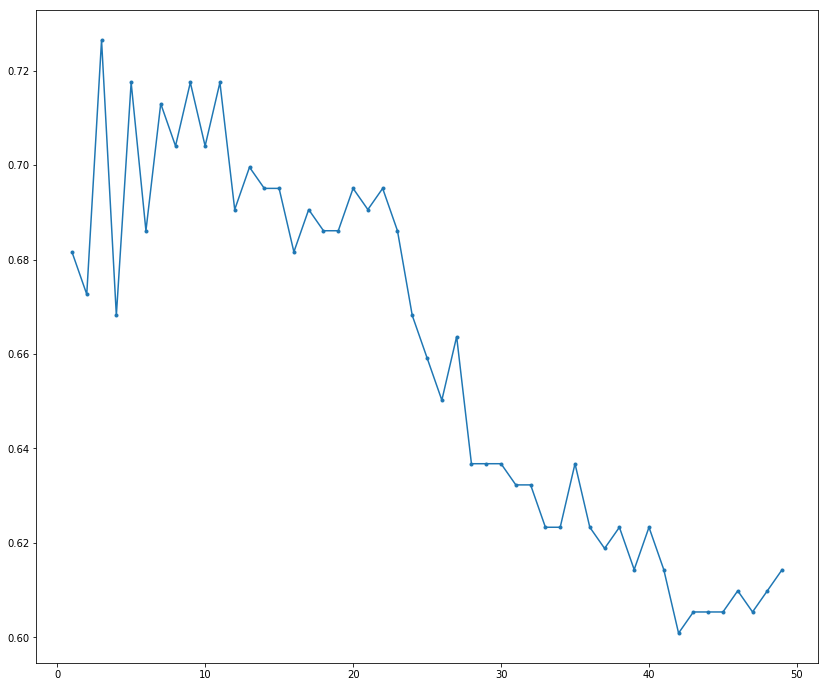

In [40]:
plt.plot(range(1,50), score,'.-')
plt.show()

In [41]:
from sklearn import model_selection
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0) 
grid_bool = [True, False]
C_param_range = [0.001,0.01,0.1,0.2,1,10,11,12,13,20, 30, 40]
grid_ratio_list = [.1, .25, .5, .75, 1.0]
clf_list = [LogisticRegression(), SVC()]
grid_param_list = [[{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'C': C_param_range
             }],
             [{
            'C': C_param_range,
             'gamma': grid_ratio_list
             }]]
for clf, param in zip (clf_list, grid_param_list):
    best_search = model_selection.GridSearchCV(estimator = clf, param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(X, y)
    best_param = best_search.best_params_
    best_error = best_search.best_score_
    print('The best parameter for {} is {} with a runtime of seconds with a score of {}'.format(clf.__class__.__name__, best_param, best_error))
    clf.set_params(**best_param) 

The best parameter for LogisticRegression is {'fit_intercept': True, 'C': 30} with a runtime of seconds with a score of 0.8583756196135148
The best parameter for SVC is {'C': 1, 'gamma': 0.1} with a runtime of seconds with a score of 0.7919877732476456


In [42]:
from sklearn.model_selection import cross_val_score
# logistic regression
C_param_range = [0.001,0.01,0.1,0.2,1,10,11,12,13]
score = []
for c in C_param_range:
    logreg = LogisticRegression(C = c)
    logreg.fit(Xtrain, ytrain)
    ypredict = logreg.predict(Xtest)
    lgscore = (metrics.accuracy_score(ytest, ypredict))
    scores = cross_val_score(logreg, X, y, cv = 5)
    print("Accuracy %0.4f" % scores.mean(), "C = ", c)

Accuracy 0.6959 C =  0.001
Accuracy 0.7722 C =  0.01
Accuracy 0.7980 C =  0.1
Accuracy 0.7946 C =  0.2
Accuracy 0.8070 C =  1
Accuracy 0.8059 C =  10
Accuracy 0.8047 C =  11
Accuracy 0.8047 C =  12
Accuracy 0.8036 C =  13


In [43]:
C_max = 10
logreg = LogisticRegression(C = C_max, fit_intercept=True)
logreg.fit(Xtrain, ytrain)
ypredict = logreg.predict(Xtest)
lgscore = (metrics.accuracy_score(ytest, ypredict))
print(lgscore)
metrics.confusion_matrix(ytest, ypredict)

0.793721973094


array([[113,  15],
       [ 31,  64]])

In [44]:
len(ytest)

223

In [45]:
# Naive Baise
from sklearn.naive_bayes import GaussianNB
naiveB = GaussianNB()
naiveB.fit(Xtrain, ytrain)
ypredict = naiveB.predict(Xtest)
nbscore = (metrics.accuracy_score(ytest, ypredict))
print(nbscore)
metrics.confusion_matrix(ytest, ypredict)

0.7533632287


array([[103,  25],
       [ 30,  65]])

In [46]:
# SVM
C_max = 1
svmclf = SVC(C = C_max, gamma=0.1)
svmclf.fit(Xtrain, ytrain)
ypredict = svmclf.predict(Xtest)
svmscore = metrics.accuracy_score(ytest, ypredict)
print(svmscore)
metrics.confusion_matrix(ytest, ypredict)

0.699551569507


array([[111,  17],
       [ 50,  45]])

## From the above comparisons Logistic Regression with an accuracy of 0.83 is the best predictor 

In [47]:
C_max = 30
logreg = LogisticRegression(C = C_max, fit_intercept = True, random_state = 0)
logreg.fit(X, y)
arpredict = logreg.predict(Xtest)
metrics.accuracy_score(ytest, arpredict)

0.80269058295964124

In [48]:
testDataTemp = testData[selectedFeatures]
arPredict = logreg.predict(testDataTemp)

In [49]:
testDataTemp.head()

,Pclass,SexCode,Age,Fare,TitleCode,Nfamily,IsAlone,EmbarkedCode,IsChild
0,3,1,34.5,7.8292,0,0,1,1,0
1,3,0,47.0,7.0000,1,1,0,0,0
2,2,1,62.0,9.6875,0,0,1,1,0
3,3,1,27.0,8.6625,0,0,1,0,0
4,3,0,22.0,12.2875,1,2,0,0,0


In [50]:
yPredict = pd.DataFrame({'PassengerId':testData['PassengerId'], 'Survived': arPredict})

In [51]:
yPredict.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [52]:
yPredict.to_csv('../predictions.csv', index = False)
yPredict.shape

(418, 2)

In [53]:
X.head()

,Pclass,SexCode,Age,Fare,TitleCode,Nfamily,IsAlone,EmbarkedCode,IsChild
0,3,1,22.0,7.2500,0,1,0,0,0
1,1,0,38.0,71.2833,1,1,0,2,0
2,3,0,26.0,7.9250,2,0,1,0,0
3,1,0,35.0,53.1000,1,1,0,0,0
4,3,1,35.0,8.0500,0,0,1,0,0


In [54]:
testDataTemp.head()

,Pclass,SexCode,Age,Fare,TitleCode,Nfamily,IsAlone,EmbarkedCode,IsChild
0,3,1,34.5,7.8292,0,0,1,1,0
1,3,0,47.0,7.0000,1,1,0,0,0
2,2,1,62.0,9.6875,0,0,1,1,0
3,3,1,27.0,8.6625,0,0,1,0,0
4,3,0,22.0,12.2875,1,2,0,0,0


In [55]:
sum(trData['Survived'])

342

In [56]:
len(trData['Survived'])

891

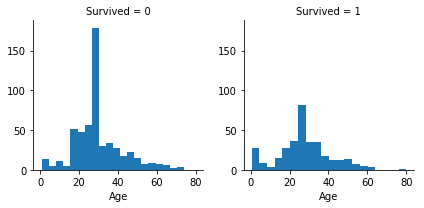

In [57]:
import seaborn as sns
g = sns.FacetGrid(trData, col='Survived')
g.map(plt.hist, 'Age', bins=20)
plt.show()

In [ ]:
grid = sns.FacetGrid(trData, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(trData['Name'])